## Sentiment Classification 😺


In this baseline we will be training an sklearn model to do a multi-class classificattion of sentiment from face embeddings. 

## Downloading Dataset

Installing puzzle datasets via `aicrowd-cli`

In [1]:
# !pip install aicrowd-cli
# Make sure to re-run below code whenever you restart colab notebook
%load_ext aicrowd.magic
%aicrowd login

Please login here: https://api.aicrowd.com/auth/6_ES6yJge6keWWBiYsbP4gke_-lEA2I-XojQkk08SLg
API Key valid
Gitlab access token valid
Saved details successfully!


In [2]:
# Creating a new data directory and downloading the dataset 
!rm -rf data
!mkdir data
%aicrowd ds dl -c sentiment-classification -o data

test.csv:   0%|          | 0.00/30.9M [00:00<?, ?B/s]


test.csv:   7%|▋         | 2.10M/30.9M [00:01<00:15, 1.91MB/s]
test.csv:  10%|█         | 3.15M/30.9M [00:01<00:14, 1.90MB/s]

test.csv:  14%|█▎        | 4.19M/30.9M [00:02<00:10, 2.43MB/s]


test.csv:  17%|█▋        | 5.24M/30.9M [00:02<00:11, 2.23MB/s]
test.csv:  20%|██        | 6.29M/30.9M [00:02<00:09, 2.58MB/s]

test.csv:  24%|██▍       | 7.34M/30.9M [00:03<00:10, 2.17MB/s]


test.csv:  27%|██▋       | 8.39M/30.9M [00:03<00:08, 2.54MB/s]


test.csv:  31%|███       | 9.44M/30.9M [00:04<00:10, 2.03MB/s]




test.csv:  37%|███▋      | 11.5M/30.9M [00:05<00:09, 2.10MB/s]




test.csv:  44%|████▍     | 13.6M/30.9M [00:06<00:07, 2.28MB/s]


test.csv:  48%|████▊     | 14.7M/30.9M [00:06<00:06, 2.58MB/s]
test.csv:  51%|█████     | 15.7M/30.9M [00:06<00:05, 2.74MB/s]




test.csv:  54%|█████▍    | 16.8M/30.9M [00:07<00:06, 2.11MB/s]


test.csv:  58%|█████▊    | 17.8M/30.9M [00:07<00:05, 2.36MB/s]



test.csv:  61%|██████    | 18.9M/30

## Importing Libraries

In [3]:
import pandas as pd
import os
import numpy as np
from ast import literal_eval
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn import decomposition
from sklearn.metrics import f1_score, accuracy_score

random.seed(42)

### Helper function

In [4]:
n_row, n_col = 2, 3

def plot_gallery(title, images, image_shape, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 1.5 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vec = np.asarray(vec)
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

def centering(data: np.array):
    n_samples, n_features = data.shape
    data = data - data.mean(axis=0)
    data -= data.mean(axis=1).reshape(n_samples, -1)
    return data

## Open Dataset and do simple preprocessing

In [5]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
sub_df = pd.read_csv("data/sample_submission.csv")

train_df.head()

,embeddings,label
0,"[0.3206779360771179, 0.988215982913971, 1.0441...",positive
1,"[0.05074610561132431, 1.0742985010147095, 0.60...",negative
2,"[0.41962647438049316, 0.4505457878112793, 1.39...",negative
3,"[0.4361684024333954, 0.19191382825374603, 0.83...",positive
4,"[0.6382085084915161, 0.8352395296096802, 0.393...",neutral


<AxesSubplot:>

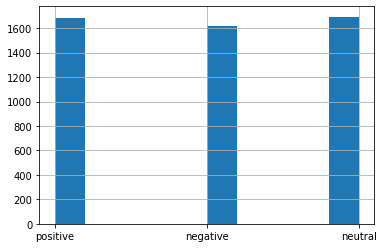

In [6]:
train_df['label'].hist()

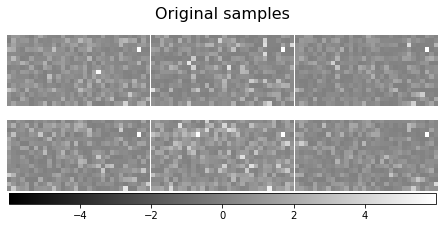

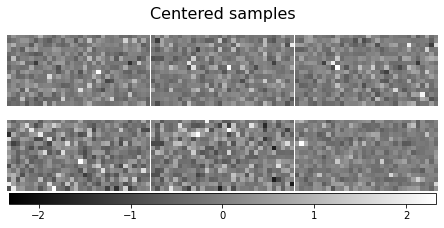

Train shape: (5000, 512)
Validation shape: (2000, 512)


In [7]:
# Getting the feature and labels from each set. 
X_train = np.array([literal_eval(embedding)  for embedding in train_df['embeddings'].values])
y_train = train_df['label'].values

X_val = np.array([literal_eval(embedding)  for embedding in val_df['embeddings'].values])
y_val = val_df['label'].values

# --- Representaion for original samples
plot_gallery("Original samples", X_train[:6], image_shape=(16, 32))

X_train = centering(X_train)
X_val = centering(X_val)

# --- Representaion for centered samples
plot_gallery("Centered samples", X_train[:6], image_shape=(16, 32))

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

## Training the model

Here, we will be training our model using the training set. 

In [8]:
params = {
    'colsample_bytree': 0.45,
    'learning_rate': 0.057,
    'max_depth': 14,
    'min_child_weight': 20.0,
    'n_estimators': 450,
    'num_leaves': 5,
    'random_state': 1,
    'reg_lambda': 2.0,
    'subsample': 0.99,
    'subsample_freq': 6
}

clf = lgb.LGBMClassifier(**params).fit(X_train, y_train)

### Testing the Model

Here, we will be evaluator our model using validation set 

In [9]:
y_pred = clf.predict(X_val)

print(f"F1 Score : {f1_score(y_val, y_pred, average='weighted')}")
print(f"Accuracy Score : {accuracy_score(y_val, y_pred)}")

F1 Score : 0.743458190668219
Accuracy Score : 0.7435


## Generating the Predictions

Generating Predictions from test data to make submission in the puzzle. 

In [10]:
submission_embeddings = np.array([literal_eval(embedding)  for embedding in sub_df['embeddings'].values])

predictions = clf.predict(centering(submission_embeddings))
sub_df['label'] = predictions
sub_df

,embeddings,label
0,"[0.08109518140554428, 0.3090009093284607, 1.36...",positive
1,"[0.6809610724449158, 1.1909409761428833, 0.892...",negative
2,"[0.14851869642734528, 0.7872061133384705, 0.89...",neutral
3,"[0.44697386026382446, 0.36429283022880554, 0.7...",neutral
4,"[1.8009324073791504, 0.26081395149230957, 0.40...",negative
...,...,...
2996,"[0.9138844609260559, 0.9460961222648621, 0.571...",negative
2997,"[0.7667452096939087, 0.7896291613578796, 0.648...",negative
2998,"[0.8158280849456787, 2.404792070388794, 0.9924...",neutral
2999,"[0.4161085784435272, 0.3146701455116272, 1.139...",positive


### Saving the Predictions

In [11]:
# Saving the predictions
!rm -rf assets
!mkdir assets
sub_df.to_csv(os.path.join("assets", "submission.csv"))